In [3]:
import pandas as pd
import numpy as np
import re
import os
import sys

sys.path.append(os.path.relpath("../src/"))
from dataloader import S1, S2, S3, S4
import emg
from utils import create_sliding_window_features 
from multilabel import MultilabelPredictor
from autogluon.tabular import TabularDataset, TabularPredictor

In [4]:
import logging, datetime

log_format = '%(asctime)s [%(levelname)s] %(message)s'
log_filename = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
logging.basicConfig(format=log_format, 
                    force=True,
                    handlers=[
                        logging.FileHandler(f"../log/{log_filename}.log"),
                        logging.StreamHandler()
                        ],
                    level=logging.INFO
                    )

### data splitter

In [15]:
feature_path_prefix = '../features/scenario_1/train/'
annotation_path_prefix = '../data/scenario_1/train/annotations/'
save_prefix = '../splitted_data/feature/'
s1 = S1()

validation_pairs = []
for sub in s1.train_subs[::5]:
    for vid in s1.train_vids[::2]:
        validation_pairs.append((sub, vid))
        
for sub, vid in validation_pairs:
    features = pd.read_csv(os.path.join(feature_path_prefix, f'sub_{sub}_vid_{vid}.csv'), index_col='time')
    annotations = pd.read_csv(os.path.join(annotation_path_prefix, f'sub_{sub}_vid_{vid}.csv'), index_col='time')
    
    df = pd.concat([features, annotations], axis=1)
    
    length = len(df)
    
    train_length = int(length * 0.8)
    test_length = length - train_length

    # train_data = df[:train_length]
    # test_data = df[train_length:]
    df[:train_length].to_csv(os.path.join(save_prefix, 'scenario_1/train', f'sub_{sub}_vid_{vid}.csv'), index_label='time')
    df[train_length:].to_csv(os.path.join(save_prefix, 'scenario_1/test', f'sub_{sub}_vid_{vid}.csv'), index_label='time')

In [16]:
validation_pairs

[(1, 1),
 (1, 10),
 (1, 13),
 (1, 18),
 (9, 1),
 (9, 10),
 (9, 13),
 (9, 18),
 (17, 1),
 (17, 10),
 (17, 13),
 (17, 18),
 (26, 1),
 (26, 10),
 (26, 13),
 (26, 18),
 (32, 1),
 (32, 10),
 (32, 13),
 (32, 18),
 (37, 1),
 (37, 10),
 (37, 13),
 (37, 18)]

### training on featrues

In [31]:
save_prefix = '../splitted_data/feature/'
label = 'arousal'

subjectID = []
videoID = []

root_mean_squared_error = []

list_predictions = []

for sub, vid in validation_pairs:
    subjectID.append(sub)
    videoID.append(vid)
    
    train_data = TabularDataset(os.path.join(save_prefix, f'scenario_1/train', f'sub_{sub}_vid_{vid}.csv'))
    train_data = train_data.fillna(0)
    train_data = train_data.drop(columns=['valence'])
    predictor = TabularPredictor(label=label, problem_type='regression', path=f'AutogluonModels/scenario_1/model/feature_sub_vid_dependent/sub_{sub}_vid_{vid}_arousal', verbosity=0).fit(train_data, ag_args_fit={'num_gpus': 1})
    
    predictor = TabularPredictor.load(f'AutogluonModels/scenario_1/model/feature_sub_vid_dependent/sub_{sub}_vid_{vid}_arousal')

    test_data = TabularDataset(os.path.join(save_prefix, f'scenario_1/test', f'sub_{sub}_vid_{vid}.csv'))
    y_test = test_data[label]
    test_data_nolab = test_data.drop(columns=[label, 'valence'])
    test_data_nolab = test_data_nolab.fillna(0)

    
    y_pred = predictor.predict(test_data_nolab)
    subjectID_pred = []
    videoID_pred = []
    
    for i in range(len(y_pred)):
        subjectID_pred.append(sub)
        videoID_pred.append(vid)
    
    predictions_dataframe = pd.DataFrame({'subjectID': subjectID_pred, 'videoID': videoID_pred, 'y_true': y_test, 'y_pred': y_pred})
    
    list_predictions.append(predictions_dataframe)
        
    rmse = np.sqrt(((y_pred - y_test) ** 2).mean())
    logging.info(f'Sub {sub} Vid {vid} RMSE: {rmse}')

    root_mean_squared_error.append(rmse)
    perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

evaluation_dataframe = pd.DataFrame({'subjectID': subjectID, 'videoID': videoID, 'root_mean_squared_error': root_mean_squared_error})

evaluation_dataframe.to_csv(f'AutogluonModels/scenario_1/output/comparison_feature_rmse_arousal_fillna.csv')
pd.concat(list_predictions, axis=0).to_csv(f'AutogluonModels/scenario_1/output/comparison_feature_prediction_arousal_fillna.csv')

2023-04-24 12:40:06,643 [INFO] Sub 1 Vid 1 RMSE: 0.1851099159556773
2023-04-24 12:41:15,597 [INFO] Sub 1 Vid 10 RMSE: 0.025752402418878502
2023-04-24 12:41:56,640 [INFO] Sub 1 Vid 13 RMSE: 0.2738819557568927
2023-04-24 12:43:02,990 [INFO] Sub 1 Vid 18 RMSE: 0.5946329671266043
2023-04-24 12:43:57,380 [INFO] Sub 9 Vid 1 RMSE: 0.29909925614763105
2023-04-24 12:44:25,553 [INFO] Sub 9 Vid 10 RMSE: 0.3089960405609499
2023-04-24 12:45:04,493 [INFO] Sub 9 Vid 13 RMSE: 0.37788345874908663
2023-04-24 12:45:51,406 [INFO] Sub 9 Vid 18 RMSE: 0.8835045665019308
2023-04-24 12:46:46,807 [INFO] Sub 17 Vid 1 RMSE: 0.41414103725275375
2023-04-24 12:47:44,898 [INFO] Sub 17 Vid 10 RMSE: 0.1164221118684602
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
2023-04-24 12:48:15,190 [INFO] Sub 17 Vid 13 RMSE: 0.6138101020146132
2023-04-24 12:50:09,563 [INF

In [28]:
save_prefix = '../splitted_data/feature/'
label = 'valence'

subjectID = []
videoID = []

root_mean_squared_error = []

list_predictions = []

for sub, vid in validation_pairs:
    subjectID.append(sub)
    videoID.append(vid)
    
    train_data = TabularDataset(os.path.join(save_prefix, f'scenario_1/train', f'sub_{sub}_vid_{vid}.csv'))
    train_data = train_data.fillna(0)
    train_data = train_data.drop(columns=['arousal'])
    predictor = TabularPredictor(label=label, problem_type='regression', path=f'AutogluonModels/scenario_1/model/feature_sub_vid_dependent/sub_{sub}_vid_{vid}_valence', verbosity=0).fit(train_data, ag_args_fit={'num_gpus': 1})
    
    predictor = TabularPredictor.load(f'AutogluonModels/scenario_1/model/feature_sub_vid_dependent/sub_{sub}_vid_{vid}_valence')

    test_data = TabularDataset(os.path.join(save_prefix, f'scenario_1/test', f'sub_{sub}_vid_{vid}.csv'))
    y_test = test_data[label]
    test_data_nolab = test_data.drop(columns=[label, 'arousal'])
    test_data_nolab = test_data_nolab.fillna(0)
    
    y_pred = predictor.predict(test_data_nolab)
    subjectID_pred = []
    videoID_pred = []
    
    for i in range(len(y_pred)):
        subjectID_pred.append(sub)
        videoID_pred.append(vid)
    
    predictions_dataframe = pd.DataFrame({'subjectID': subjectID_pred, 'videoID': videoID_pred, 'y_true': y_test, 'y_pred': y_pred})
    
    list_predictions.append(predictions_dataframe)
        
    rmse = np.sqrt(((y_pred - y_test) ** 2).mean())
    logging.info(f'Sub {sub} Vid {vid} RMSE: {rmse}')

    root_mean_squared_error.append(rmse)
    perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)
    print(rmse, perf['root_mean_squared_error'])

evaluation_dataframe = pd.DataFrame({'subjectID': subjectID, 'videoID': videoID, 'root_mean_squared_error': root_mean_squared_error})

evaluation_dataframe.to_csv(f'AutogluonModels/scenario_1/output/comparison_feature_rmse_valence.csv')
pd.concat(list_predictions, axis=0).to_csv(f'AutogluonModels/scenario_1/output/comparison_feature_prediction_valence.csv')

2023-04-24 11:32:08,885 [INFO] Sub 1 Vid 1 RMSE: 0.13708393460961033


0.13708393460961033 -0.13708393460961033


2023-04-24 11:32:52,352 [INFO] Sub 1 Vid 10 RMSE: 0.0031445821566913517
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


0.0031445821566913517 -0.0031445821566913517


2023-04-24 11:33:45,538 [INFO] Sub 1 Vid 13 RMSE: 0.14189398211459692
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


0.14189398211459692 -0.14189398211459692


2023-04-24 11:34:38,149 [INFO] Sub 1 Vid 18 RMSE: 0.41489447238351723


0.41489447238351723 -0.41489447238351723


2023-04-24 11:36:53,651 [INFO] Sub 9 Vid 1 RMSE: 0.7776547223350357


0.7776547223350357 -0.7776547223350357


2023-04-24 11:37:26,169 [INFO] Sub 9 Vid 10 RMSE: 0.14366127903077267


0.14366127903077267 -0.14366127903077267


2023-04-24 11:37:53,425 [INFO] Sub 9 Vid 13 RMSE: 0.13491248436879605


0.13491248436879605 -0.13491248436879605


2023-04-24 11:38:38,625 [INFO] Sub 9 Vid 18 RMSE: 0.3888741586700516


0.3888741586700516 -0.3888741586700516


2023-04-24 11:39:26,328 [INFO] Sub 17 Vid 1 RMSE: 0.08102541187381572


0.08102541187381572 -0.08102541187381572


2023-04-24 11:40:37,424 [INFO] Sub 17 Vid 10 RMSE: 0.2054379948692579


0.2054379948692579 -0.2054379948692579


2023-04-24 11:41:18,534 [INFO] Sub 17 Vid 13 RMSE: 0.41532521837132597


0.41532521837132597 -0.41532521837132597


2023-04-24 11:42:27,041 [INFO] Sub 17 Vid 18 RMSE: 0.19832244388127368


0.19832244388127368 -0.19832244388127368


2023-04-24 11:43:02,497 [INFO] Sub 26 Vid 1 RMSE: 0.05310581549353405


0.05310581549353405 -0.05310581549353405


		catboost/libs/metrics/metric.cpp:6376: All train targets are equal
2023-04-24 11:43:05,581 [INFO] Sub 26 Vid 10 RMSE: 0.0
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


0.0 -0.0


2023-04-24 11:43:46,469 [INFO] Sub 26 Vid 13 RMSE: 0.21738049559376033


0.21738049559376033 -0.21738049559376033


2023-04-24 11:44:27,945 [INFO] Sub 26 Vid 18 RMSE: 0.9415684064354306


0.9415684064354306 -0.9415684064354306


2023-04-24 11:44:59,072 [INFO] Sub 32 Vid 1 RMSE: 0.4748489243199611


0.4748489243199611 -0.4748489243199611


2023-04-24 11:45:53,662 [INFO] Sub 32 Vid 10 RMSE: 0.2335365553489719


0.2335365553489719 -0.2335365553489719


2023-04-24 11:47:56,724 [INFO] Sub 32 Vid 13 RMSE: 0.7364821745410827


0.7364821745410827 -0.7364821745410827


2023-04-24 11:49:21,551 [INFO] Sub 32 Vid 18 RMSE: 0.9190222116940195


0.9190222116940195 -0.9190222116940195


2023-04-24 11:50:18,233 [INFO] Sub 37 Vid 1 RMSE: 0.053951835372846216
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


0.053951835372846216 -0.053951835372846216


2023-04-24 11:51:18,317 [INFO] Sub 37 Vid 10 RMSE: 0.012510618570989337


0.012510618570989337 -0.012510618570989337


		catboost/libs/metrics/metric.cpp:6376: All train targets are equal
2023-04-24 11:51:21,559 [INFO] Sub 37 Vid 13 RMSE: 0.01872006084301278
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


0.01872006084301278 -0.01872006084301278


2023-04-24 11:52:30,458 [INFO] Sub 37 Vid 18 RMSE: 0.9654805363561625


0.9654805363561625 -0.9654805363561625


### training on raw data

In [29]:
save_prefix = '../splitted_data/raw/'
label = 'arousal'

subjectID = []
videoID = []

root_mean_squared_error = []

list_predictions = []

for sub, vid in validation_pairs:
    subjectID.append(sub)
    videoID.append(vid)
    
    train_data = TabularDataset(os.path.join(save_prefix, f'scenario_1/train', f'sub_{sub}_vid_{vid}.csv'))
    train_data = train_data.fillna(0)
    train_data = train_data.drop(columns=['valence'])
    predictor = TabularPredictor(label=label, problem_type='regression', path=f'AutogluonModels/scenario_1/model/raw_sub_vid_dependent/sub_{sub}_vid_{vid}_arousal', verbosity=0).fit(train_data, ag_args_fit={'num_gpus': 1})
    
    # load the model
    predictor = TabularPredictor.load(f'AutogluonModels/scenario_1/model/raw_sub_vid_dependent/sub_{sub}_vid_{vid}_arousal')

    # load test data
    test_data = TabularDataset(os.path.join(save_prefix, f'scenario_1/test', f'sub_{sub}_vid_{vid}.csv'))
    # take the true value
    y_test = test_data[label]
    # drop the label column and the other rating
    # testing arousal: label = 'arousal', drop label and 'valence'
    # testing valence: label = 'valence', drop label and 'arousal'
    test_data_nolab = test_data.drop(columns=[label, 'valence'])
    test_data_nolab = test_data_nolab.fillna(0)

    # generate the predictions
    y_pred = predictor.predict(test_data_nolab)
    # manually calculate rmse
    rmse = np.sqrt(((y_pred - y_test) ** 2).mean())
    
    # or use the evaluation function provided by autogluon
    perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)
    
    subjectID_pred = []
    videoID_pred = []
    
    for i in range(len(y_pred)):
        subjectID_pred.append(sub)
        videoID_pred.append(vid)
    
    predictions_dataframe = pd.DataFrame({'subjectID': subjectID_pred, 'videoID': videoID_pred, 'y_true': y_test, 'y_pred': y_pred})
    
    list_predictions.append(predictions_dataframe)
        
    logging.info(f'Sub {sub} Vid {vid} RMSE: {rmse}')

    root_mean_squared_error.append(rmse)
    perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

evaluation_dataframe = pd.DataFrame({'subjectID': subjectID, 'videoID': videoID, 'root_mean_squared_error': root_mean_squared_error})

evaluation_dataframe.to_csv(f'AutogluonModels/scenario_1/output/comparison_raw_rmse_arousal.csv')
pd.concat(list_predictions, axis=0).to_csv(f'AutogluonModels/scenario_1/output/comparison_raw_prediction_arousal.csv')

2023-04-24 11:53:19,636 [INFO] Sub 1 Vid 1 RMSE: 0.09541738891226419
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
2023-04-24 11:53:59,207 [INFO] Sub 1 Vid 10 RMSE: 0.007864991204704762
2023-04-24 11:54:45,725 [INFO] Sub 1 Vid 13 RMSE: 0.05281377589840203
2023-04-24 11:55:46,467 [INFO] Sub 1 Vid 18 RMSE: 0.5432367325913394
2023-04-24 11:56:50,694 [INFO] Sub 9 Vid 1 RMSE: 0.1598567254748051
2023-04-24 11:59:10,513 [INFO] Sub 9 Vid 10 RMSE: 0.01492970394068426
2023-04-24 12:00:17,698 [INFO] Sub 9 Vid 13 RMSE: 0.05988446074520219
2023-04-24 12:01:22,537 [INFO] Sub 9 Vid 18 RMSE: 2.059422580378787
2023-04-24 12:02:03,687 [INFO] Sub 17 Vid 1 RMSE: 0.26978245970870235
2023-04-24 12:02:49,212 [INFO] Sub 17 Vid 10 RMSE: 9.346008322808076e-08
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An inpu

In [30]:
save_prefix = '../splitted_data/raw/'
label = 'valence'

subjectID = []
videoID = []

root_mean_squared_error = []

list_predictions = []

for sub, vid in validation_pairs:
    subjectID.append(sub)
    videoID.append(vid)
    
    train_data = TabularDataset(os.path.join(save_prefix, f'scenario_1/train', f'sub_{sub}_vid_{vid}.csv'))
    train_data = train_data.fillna(0)
    train_data = train_data.drop(columns=['arousal'])
    predictor = TabularPredictor(label=label, problem_type='regression', path=f'AutogluonModels/scenario_1/model/raw_sub_vid_dependent/sub_{sub}_vid_{vid}_valence', verbosity=0).fit(train_data, ag_args_fit={'num_gpus': 1})
    
    predictor = TabularPredictor.load(f'AutogluonModels/scenario_1/model/raw_sub_vid_dependent/sub_{sub}_vid_{vid}_valence')

    test_data = TabularDataset(os.path.join(save_prefix, f'scenario_1/test', f'sub_{sub}_vid_{vid}.csv'))
    y_test = test_data[label]
    test_data_nolab = test_data.drop(columns=[label, 'arousal'])
    test_data_nolab = test_data_nolab.fillna(0)

    
    y_pred = predictor.predict(test_data_nolab)
    subjectID_pred = []
    videoID_pred = []
    
    for i in range(len(y_pred)):
        subjectID_pred.append(sub)
        videoID_pred.append(vid)
    
    predictions_dataframe = pd.DataFrame({'subjectID': subjectID_pred, 'videoID': videoID_pred, 'y_true': y_test, 'y_pred': y_pred})
    
    list_predictions.append(predictions_dataframe)
        
    rmse = np.sqrt(((y_pred - y_test) ** 2).mean())
    logging.info(f'Sub {sub} Vid {vid} RMSE: {rmse}')

    root_mean_squared_error.append(rmse)
    perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

evaluation_dataframe = pd.DataFrame({'subjectID': subjectID, 'videoID': videoID, 'root_mean_squared_error': root_mean_squared_error})

evaluation_dataframe.to_csv(f'AutogluonModels/scenario_1/output/comparison_raw_rmse_valence.csv')
pd.concat(list_predictions, axis=0).to_csv(f'AutogluonModels/scenario_1/output/comparison_raw_prediction_valence.csv')

2023-04-24 12:19:37,032 [INFO] Sub 1 Vid 1 RMSE: 0.10441378924663655
2023-04-24 12:20:08,695 [INFO] Sub 1 Vid 10 RMSE: 1.258850099716824e-07
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
2023-04-24 12:20:38,644 [INFO] Sub 1 Vid 13 RMSE: 0.0033179392000418726
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
2023-04-24 12:22:07,759 [INFO] Sub 1 Vid 18 RMSE: 0.2827003011558666
2023-04-24 12:22:48,204 [INFO] Sub 9 Vid 1 RMSE: 0.12338436928655945
2023-04-24 12:23:25,962 [INFO] Sub 9 Vid 10 RMSE: 0.0020498669891767405
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  

### comparison

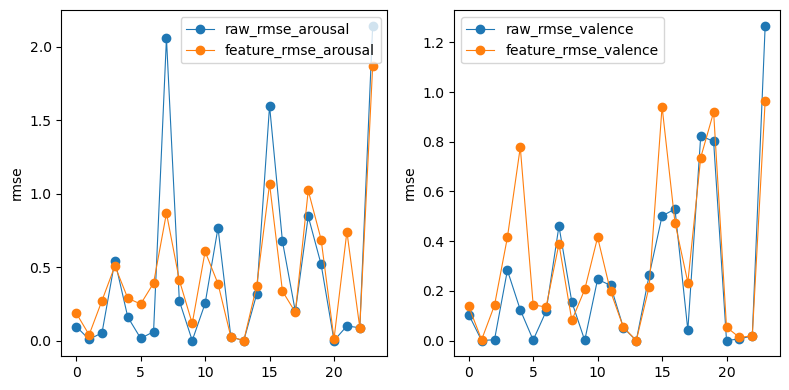

In [33]:
import matplotlib.pyplot as plt

s1 = S1()

validation_pairs = []
for sub in s1.train_subs[::5]:
    for vid in s1.train_vids[::2]:
        validation_pairs.append((sub, vid))

raw_rmse_arousal = pd.read_csv('AutogluonModels/scenario_1/output/comparison_raw_rmse_arousal.csv')
raw_rmse_valence = pd.read_csv('AutogluonModels/scenario_1/output/comparison_raw_rmse_valence.csv')
feature_rmse_arousal = pd.read_csv('AutogluonModels/scenario_1/output/comparison_feature_rmse_arousal.csv')
feature_rmse_valence = pd.read_csv('AutogluonModels/scenario_1/output/comparison_feature_rmse_valence.csv')

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes = axes.flatten()
axes[0].set_ylabel('rmse')
axes[0].plot(raw_rmse_arousal['root_mean_squared_error'], 'o-', linewidth=0.8, label='raw_rmse_arousal')
axes[0].plot(feature_rmse_arousal['root_mean_squared_error'], 'o-', linewidth=0.8, label='feature_rmse_arousal')
axes[0].legend()

axes[1].set_ylabel('rmse')
axes[1].plot(raw_rmse_valence['root_mean_squared_error'], 'o-', linewidth=0.8, label='raw_rmse_valence')
axes[1].plot(feature_rmse_valence['root_mean_squared_error'], 'o-', linewidth=0.8, label='feature_rmse_valence')

plt.legend()
plt.tight_layout()
plt.show()

In [34]:
raw_rmse_arousal['root_mean_squared_error'].mean(), feature_rmse_arousal['root_mean_squared_error'].mean()

(0.4495746558801385, 0.447199111393996)

In [35]:
raw_rmse_valence['root_mean_squared_error'].mean(), feature_rmse_valence['root_mean_squared_error'].mean()

(0.25092245151177567, 0.3195349299681048)

### multi-label predictor on raw data

In [5]:
from multilabel import MultilabelPredictor

In [37]:
save_prefix = '../splitted_data/raw/'

labels = ['arousal', 'valence']
s1 = S1()

subjectID = []
videoID = []

# root_mean_squared_error = []
list_predictions = []
arousal_rmse = []
valence_rmse = []
for sub, vid in validation_pairs:
    subjectID.append(sub)
    videoID.append(vid)
    
    train_data = TabularDataset(os.path.join(save_prefix, f'scenario_1/train', f'sub_{sub}_vid_{vid}.csv'))
    multi_predictor = MultilabelPredictor(labels=labels, problem_types=['regression', 'regression'], path=f'AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_{sub}_vid_{vid}_multilabel',
                                          eval_metrics=['root_mean_squared_error', 'rmse'], verbosity=0).fit(train_data, ag_args_fit={'num_gpus': 1}, presets='best_quality')

    multi_predictor = MultilabelPredictor.load(f'AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_{sub}_vid_{vid}_multilabel')
    
    test_data = TabularDataset(os.path.join(save_prefix, f'scenario_1/test', f'sub_{sub}_vid_{vid}.csv'))
    test_data_nolab = test_data.drop(columns=labels)
    
    predictions = multi_predictor.predict(test_data_nolab)

    subjectID_pred = []
    videoID_pred = []
    
    for i in range(len(predictions)):
        subjectID_pred.append(sub)
        videoID_pred.append(vid)
    arousal_rmse.append(np.sqrt(((predictions['arousal'] - test_data['arousal']) ** 2).mean()))
    valence_rmse.append(np.sqrt(((predictions['valence'] - test_data['valence']) ** 2).mean()))
    predictions.insert(len(predictions.columns), 'arousal_true', test_data['arousal'])
    predictions.insert(len(predictions.columns), 'valence_true', test_data['valence'])
    
    list_predictions.append(predictions)
    
    evaluations = multi_predictor.evaluate(test_data)
    print(evaluations)
    
evaluation_dataframe = pd.DataFrame({'subjectID': subjectID, 'videoID': videoID, 'arousal_rmse': arousal_rmse, 'valence_rmse': valence_rmse})
evaluation_dataframe.to_csv(f'AutogluonModels/scenario_1/output/comparison_raw_multi_label_rmse.csv')
pd.concat(list_predictions, axis=0).to_csv(f'AutogluonModels/scenario_1/output/comparison_raw_multi_label_predictions.csv')

Fitting TabularPredictor for label: arousal ...
Fitting TabularPredictor for label: valence ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_1_vid_1_multilabel/')
Predicting with TabularPredictor for label: arousal ...
Predicting with TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


Evaluating TabularPredictor for label: valence ...
{'arousal': {'root_mean_squared_error': -0.09556738382839565, 'mean_squared_error': -0.009133124851803898, 'mean_absolute_error': -0.07120011433562139, 'r2': -1.165431264091069, 'pearsonr': 0.2896373112143108, 'median_absolute_error': -0.019417205810547067}, 'valence': {'root_mean_squared_error': -0.10434763780894651, 'mean_squared_error': -0.010888429516307085, 'mean_absolute_error': -0.07334817833704162, 'r2': -0.3773273043289467, 'pearsonr': 0.3586073308575066, 'median_absolute_error': -0.07114985275268548}}
Fitting TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


Fitting TabularPredictor for label: valence ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_1_vid_10_multilabel/')
Predicting with TabularPredictor for label: arousal ...
Predicting with TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...
Evaluating TabularPredictor for label: valence ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


{'arousal': {'root_mean_squared_error': -0.007791062651507217, 'mean_squared_error': -6.070065723971066e-05, 'mean_absolute_error': -0.007592787481080709, 'r2': -18.900205156413687, 'pearsonr': nan, 'median_absolute_error': -0.00799998855590811}, 'valence': {'root_mean_squared_error': -1.258850099716824e-07, 'mean_squared_error': -1.5847035735570575e-14, 'mean_absolute_error': -1.258850099716824e-07, 'r2': 0.0, 'pearsonr': nan, 'median_absolute_error': -1.258850099716824e-07}}
Fitting TabularPredictor for label: arousal ...
Fitting TabularPredictor for label: valence ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_1_vid_13_multilabel/')
Predicting with TabularPredictor for label: arousal ...
Predicting with TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


Evaluating TabularPredictor for label: valence ...


/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


{'arousal': {'root_mean_squared_error': -0.04115630440010487, 'mean_squared_error': -0.0016938413918740917, 'mean_absolute_error': -0.030663269922288895, 'r2': -1.0809923979647995, 'pearsonr': 0.28802917686513624, 'median_absolute_error': -0.030799160003661896}, 'valence': {'root_mean_squared_error': -0.0004559767877645307, 'mean_squared_error': -2.079148309800599e-07, 'mean_absolute_error': -0.0003541789943887686, 'r2': 0.0, 'pearsonr': nan, 'median_absolute_error': -0.0004910926818846306}}
Fitting TabularPredictor for label: arousal ...
Fitting TabularPredictor for label: valence ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_1_vid_18_multilabel/')
Predicting with TabularPredictor for label: arousal ...
Predicting with TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


Evaluating TabularPredictor for label: valence ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'arousal': {'root_mean_squared_error': -0.553101682965089, 'mean_squared_error': -0.30592147169881384, 'mean_absolute_error': -0.4004540520014726, 'r2': -1.0579862194853509, 'pearsonr': 0.9651176364150875, 'median_absolute_error': -0.09399838066101118}, 'valence': {'root_mean_squared_error': -0.28370773646614195, 'mean_squared_error': -0.08049007973074183, 'mean_absolute_error': -0.24596050199373493, 'r2': -3.0798803091301616, 'pearsonr': -0.3446097320671783, 'median_absolute_error': -0.13730869388580302}}
Fitting TabularPredictor for label: arousal ...
Fitting TabularPredictor for label: valence ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_9_vid_1_multilabel/')
Predicting with TabularPredictor for label: arousal ...
Predicting with TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


Evaluating TabularPredictor for label: valence ...
{'arousal': {'root_mean_squared_error': -0.16249111263759955, 'mean_squared_error': -0.02640336168620506, 'mean_absolute_error': -0.08695384253344472, 'r2': -0.4020563126148631, 'pearsonr': -0.2011576315904689, 'median_absolute_error': -0.0017709503173826135}, 'valence': {'root_mean_squared_error': -0.12513602212076244, 'mean_squared_error': -0.015659024032207945, 'mean_absolute_error': -0.08520208462465113, 'r2': -0.1217955758739151, 'pearsonr': -0.020457628731584167, 'median_absolute_error': -0.03860076522827072}}
Fitting TabularPredictor for label: arousal ...
Fitting TabularPredictor for label: valence ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_9_vid_10_multilabel/')
Predicting with TabularPredictor for label: arousal ...
Predicting with TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


Evaluating TabularPredictor for label: valence ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'arousal': {'root_mean_squared_error': -0.014937969077637153, 'mean_squared_error': -0.00022314292016444379, 'mean_absolute_error': -0.013172114464714935, 'r2': -3.4987417379918, 'pearsonr': -0.08899663613462629, 'median_absolute_error': -0.018007104873657198}, 'valence': {'root_mean_squared_error': -0.0021130048034222206, 'mean_squared_error': -4.464789299285377e-06, 'mean_absolute_error': -0.0012197099828324459, 'r2': -0.4979451087753861, 'pearsonr': 0.046382000011573235, 'median_absolute_error': -0.00010335540771500007}}
Fitting TabularPredictor for label: arousal ...
Fitting TabularPredictor for label: valence ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_9_vid_13_multilabel/')
Predicting with TabularPredictor for label: arousal ...
Predicting with TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...
Evaluating TabularPredictor for label: valenc

/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'arousal': {'root_mean_squared_error': -0.059570312719060284, 'mean_squared_error': -0.0035486221574466356, 'mean_absolute_error': -0.04165453879146238, 'r2': -0.9606701083541349, 'pearsonr': -0.15341850331755655, 'median_absolute_error': -0.016346885681151946}, 'valence': {'root_mean_squared_error': -0.12124516081811708, 'mean_squared_error': -0.014700389021811073, 'mean_absolute_error': -0.0967981673935712, 'r2': -1.761377007187642, 'pearsonr': 0.0014884025730317336, 'median_absolute_error': -0.060148078918457415}}
Fitting TabularPredictor for label: arousal ...
Fitting TabularPredictor for label: valence ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_9_vid_18_multilabel/')
Predicting with TabularPredictor for label: arousal ...
Predicting with TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...
Evaluating TabularPredictor for label: valence ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'arousal': {'root_mean_squared_error': -2.0500178042617683, 'mean_squared_error': -4.202572997790242, 'mean_absolute_error': -1.8724763553574326, 'r2': -5.021011402119635, 'pearsonr': 0.3718527255713611, 'median_absolute_error': -1.1919834156036373}, 'valence': {'root_mean_squared_error': -0.4081437153082763, 'mean_squared_error': -0.16658129234564328, 'mean_absolute_error': -0.2930930979739962, 'r2': -0.7164947764947422, 'pearsonr': 0.17792261050326075, 'median_absolute_error': -0.04524801063537587}}
Fitting TabularPredictor for label: arousal ...
Fitting TabularPredictor for label: valence ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_17_vid_1_multilabel/')
Predicting with TabularPredictor for label: arousal ...
Predicting with TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


Evaluating TabularPredictor for label: valence ...
{'arousal': {'root_mean_squared_error': -0.26905429509107776, 'mean_squared_error': -0.07239021370695675, 'mean_absolute_error': -0.2517954834317698, 'r2': -7.092870110093244, 'pearsonr': -0.5098455162369361, 'median_absolute_error': -0.2698167095184325}, 'valence': {'root_mean_squared_error': -0.15327335716077292, 'mean_squared_error': -0.02349272201533386, 'mean_absolute_error': -0.1280948504846074, 'r2': -2.2836607945048373, 'pearsonr': -0.05170450844449215, 'median_absolute_error': -0.14999894714355477}}
Fitting TabularPredictor for label: arousal ...
Fitting TabularPredictor for label: valence ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_17_vid_10_multilabel/')
Predicting with TabularPredictor for label: arousal ...
Predicting with TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Evaluating TabularPredictor for label: valence ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'arousal': {'root_mean_squared_error': -4.099493988492435e-05, 'mean_squared_error': -1.6805850961685612e-09, 'mean_absolute_error': -2.7044798198627922e-05, 'r2': 0.0, 'pearsonr': nan, 'median_absolute_error': -1.1827468871850044e-05}, 'valence': {'root_mean_squared_error': -0.001761204486870149, 'mean_squared_error': -3.1018412445715446e-06, 'mean_absolute_error': -0.00115171480046746, 'r2': -6.385986713572634, 'pearsonr': 0.0783302331462532, 'median_absolute_error': -0.0004210090637206676}}
Fitting TabularPredictor for label: arousal ...
Fitting TabularPredictor for label: valence ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_17_vid_13_multilabel/')
Predicting with TabularPredictor for label: arousal ...
Predicting with TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


Evaluating TabularPredictor for label: valence ...
{'arousal': {'root_mean_squared_error': -0.2528414433768021, 'mean_squared_error': -0.06392879548886463, 'mean_absolute_error': -0.22271490197909083, 'r2': -3.474064847373479, 'pearsonr': -0.07681175396594417, 'median_absolute_error': -0.19005820465087897}, 'valence': {'root_mean_squared_error': -0.24503211073783346, 'mean_squared_error': -0.06004073529263788, 'mean_absolute_error': -0.20409003844180346, 'r2': -2.3882825297037353, 'pearsonr': -0.7765284067991721, 'median_absolute_error': -0.17936468124389648}}
Fitting TabularPredictor for label: arousal ...
Fitting TabularPredictor for label: valence ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_17_vid_18_multilabel/')
Predicting with TabularPredictor for label: arousal ...
Predicting with TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


Evaluating TabularPredictor for label: valence ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'arousal': {'root_mean_squared_error': -0.7711562592620091, 'mean_squared_error': -0.5946819761989751, 'mean_absolute_error': -0.6453589015119658, 'r2': -2.1925487960276238, 'pearsonr': 0.6009511791825611, 'median_absolute_error': -0.42037564277648887}, 'valence': {'root_mean_squared_error': -0.22753997330188053, 'mean_squared_error': -0.051774439450220505, 'mean_absolute_error': -0.16923438842653293, 'r2': -1.2315196413719622, 'pearsonr': 0.3419163820174015, 'median_absolute_error': -0.19167224884033196}}
Fitting TabularPredictor for label: arousal ...
Fitting TabularPredictor for label: valence ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_26_vid_1_multilabel/')
Predicting with TabularPredictor for label: arousal ...
Predicting with TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


Evaluating TabularPredictor for label: valence ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'arousal': {'root_mean_squared_error': -0.025988974787325623, 'mean_squared_error': -0.0006754268104962469, 'mean_absolute_error': -0.013192479439152393, 'r2': -0.4874329759008449, 'pearsonr': -0.6745663122087417, 'median_absolute_error': -0.003151012420654631}, 'valence': {'root_mean_squared_error': -0.04977553646135817, 'mean_squared_error': -0.0024776040300159966, 'mean_absolute_error': -0.03886322763128219, 'r2': 0.11195292280578995, 'pearsonr': 0.41925309095832397, 'median_absolute_error': -0.02983553504943881}}
Fitting TabularPredictor for label: arousal ...


		ray::_ray_fit() (pid=358722, ip=163.221.174.171)
  File "/home/celia/.local/lib/python3.10/site-packages/autogluon/core/models/ensemble/fold_fitting_strategy.py", line 374, in _ray_fit
    fold_model.fit(X=X_fold, y=y_fold, X_val=X_val_fold, y_val=y_val_fold,
  File "/home/celia/.local/lib/python3.10/site-packages/autogluon/core/models/abstract/abstract_model.py", line 703, in fit
    out = self._fit(**kwargs)
  File "/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/models/catboost/catboost_model.py", line 212, in _fit
    self.model.fit(X, **fit_final_kwargs)
  File "/home/celia/.local/lib/python3.10/site-packages/catboost/core.py", line 5730, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "/home/celia/.local/lib/python3.10/site-packages/catboost/core.py", line 2355, in _fit
    self._train(
  File "/home/celia/.local/lib/python3.10/site-packages/catboost/core.py", line

Fitting TabularPredictor for label: valence ...


		ray::_ray_fit() (pid=367358, ip=163.221.174.171)
  File "/home/celia/.local/lib/python3.10/site-packages/autogluon/core/models/ensemble/fold_fitting_strategy.py", line 374, in _ray_fit
    fold_model.fit(X=X_fold, y=y_fold, X_val=X_val_fold, y_val=y_val_fold,
  File "/home/celia/.local/lib/python3.10/site-packages/autogluon/core/models/abstract/abstract_model.py", line 703, in fit
    out = self._fit(**kwargs)
  File "/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/models/catboost/catboost_model.py", line 212, in _fit
    self.model.fit(X, **fit_final_kwargs)
  File "/home/celia/.local/lib/python3.10/site-packages/catboost/core.py", line 5730, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "/home/celia/.local/lib/python3.10/site-packages/catboost/core.py", line 2355, in _fit
    self._train(
  File "/home/celia/.local/lib/python3.10/site-packages/catboost/core.py", line

MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_26_vid_10_multilabel/')
Predicting with TabularPredictor for label: arousal ...
Predicting with TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...
Evaluating TabularPredictor for label: valence ...
{'arousal': {'root_mean_squared_error': -0.0, 'mean_squared_error': -0.0, 'mean_absolute_error': -0.0, 'r2': 1.0, 'pearsonr': nan, 'median_absolute_error': -0.0}, 'valence': {'root_mean_squared_error': -0.0, 'mean_squared_error': -0.0, 'mean_absolute_error': -0.0, 'r2': 1.0, 'pearsonr': nan, 'median_absolute_error': -0.0}}
Fitting TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Fitting TabularPredictor for label: valence ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_26_vid_13_multilabel/')
Predicting with TabularPredictor for label: arousal ...
Predicting with TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...
Evaluating TabularPredictor for label: valence ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'arousal': {'root_mean_squared_error': -0.3153131925605705, 'mean_squared_error': -0.0994224094027394, 'mean_absolute_error': -0.23662691783581735, 'r2': -1.2892505974811796, 'pearsonr': nan, 'median_absolute_error': -0.1269997978210453}, 'valence': {'root_mean_squared_error': -0.26311643656366873, 'mean_squared_error': -0.0692302591899631, 'mean_absolute_error': -0.24453944889650497, 'r2': -6.312402633058896, 'pearsonr': 0.4383872916680741, 'median_absolute_error': -0.29843503570556607}}
Fitting TabularPredictor for label: arousal ...
Fitting TabularPredictor for label: valence ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_26_vid_18_multilabel/')
Predicting with TabularPredictor for label: arousal ...
Predicting with TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


Evaluating TabularPredictor for label: valence ...
{'arousal': {'root_mean_squared_error': -1.5468561588560532, 'mean_squared_error': -2.392763976190903, 'mean_absolute_error': -1.1783229010424279, 'r2': -0.9523026478004946, 'pearsonr': -0.21101726683644206, 'median_absolute_error': -0.5446655330657957}, 'valence': {'root_mean_squared_error': -0.3764171537419906, 'mean_squared_error': -0.14168987363122137, 'mean_absolute_error': -0.3307548689213325, 'r2': -3.6812440510553888, 'pearsonr': -0.5495546143269997, 'median_absolute_error': -0.4388622045516968}}
Fitting TabularPredictor for label: arousal ...
Fitting TabularPredictor for label: valence ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_32_vid_1_multilabel/')
Predicting with TabularPredictor for label: arousal ...
Predicting with TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...
Evaluating Tabu

/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


{'arousal': {'root_mean_squared_error': -0.6755115384402749, 'mean_squared_error': -0.45631583856594704, 'mean_absolute_error': -0.6689715656807002, 'r2': -52.76799836703925, 'pearsonr': -0.717684872832047, 'median_absolute_error': -0.6883642578125002}, 'valence': {'root_mean_squared_error': -0.5292697158162482, 'mean_squared_error': -0.2801264320802121, 'mean_absolute_error': -0.48905567500781805, 'r2': -2.0243795456927876, 'pearsonr': nan, 'median_absolute_error': -0.6069999732971194}}
Fitting TabularPredictor for label: arousal ...
Fitting TabularPredictor for label: valence ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_32_vid_10_multilabel/')
Predicting with TabularPredictor for label: arousal ...
Predicting with TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...
Evaluating TabularPredictor for label: valence ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'arousal': {'root_mean_squared_error': -0.19804329776443547, 'mean_squared_error': -0.03922114778941285, 'mean_absolute_error': -0.14418563485607874, 'r2': -0.36751998187039625, 'pearsonr': nan, 'median_absolute_error': -0.11700009918212917}, 'valence': {'root_mean_squared_error': -0.040346874031752626, 'mean_squared_error': -0.0016278702441341146, 'mean_absolute_error': -0.03216110553899957, 'r2': -0.3547204126150689, 'pearsonr': -0.13878436380879525, 'median_absolute_error': -0.016430377960205078}}
Fitting TabularPredictor for label: arousal ...
Fitting TabularPredictor for label: valence ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_32_vid_13_multilabel/')
Predicting with TabularPredictor for label: arousal ...
Predicting with TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...
Evaluating TabularPredictor for label: valence ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'arousal': {'root_mean_squared_error': -0.8461854211509551, 'mean_squared_error': -0.7160297669684191, 'mean_absolute_error': -0.8010180696778378, 'r2': -8.512015447009667, 'pearsonr': 0.6798246588113737, 'median_absolute_error': -0.8898046264648434}, 'valence': {'root_mean_squared_error': -0.823652085316196, 'mean_squared_error': -0.6784027576457183, 'mean_absolute_error': -0.6897370090032029, 'r2': -2.0901898377126753, 'pearsonr': -0.03025463996893554, 'median_absolute_error': -0.8256764793395996}}
Fitting TabularPredictor for label: arousal ...
Fitting TabularPredictor for label: valence ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_32_vid_18_multilabel/')
Predicting with TabularPredictor for label: arousal ...
Predicting with TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


Evaluating TabularPredictor for label: valence ...
{'arousal': {'root_mean_squared_error': -0.514852690386779, 'mean_squared_error': -0.26507329279850456, 'mean_absolute_error': -0.359454923029021, 'r2': -0.9332195443656712, 'pearsonr': 0.2136339315155349, 'median_absolute_error': -0.024532276153563792}, 'valence': {'root_mean_squared_error': -0.8112916562909208, 'mean_squared_error': -0.6581941515672656, 'mean_absolute_error': -0.5406141349011516, 'r2': -0.5841966080631844, 'pearsonr': nan, 'median_absolute_error': -0.027999958038329886}}
Fitting TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Fitting TabularPredictor for label: valence ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_37_vid_1_multilabel/')
Predicting with TabularPredictor for label: arousal ...
Predicting with TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...
Evaluating TabularPredictor for label: valence ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


{'arousal': {'root_mean_squared_error': -0.0, 'mean_squared_error': -0.0, 'mean_absolute_error': -0.0, 'r2': 1.0, 'pearsonr': nan, 'median_absolute_error': -0.0}, 'valence': {'root_mean_squared_error': -6.206641939587865e-05, 'mean_squared_error': -3.852240416625101e-09, 'mean_absolute_error': -1.1579504290830742e-05, 'r2': 0.0, 'pearsonr': nan, 'median_absolute_error': -4.76837158203125e-07}}
Fitting TabularPredictor for label: arousal ...
Fitting TabularPredictor for label: valence ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_37_vid_10_multilabel/')
Predicting with TabularPredictor for label: arousal ...
Predicting with TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...
Evaluating TabularPredictor for label: valence ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


{'arousal': {'root_mean_squared_error': -0.09885862958525297, 'mean_squared_error': -0.009773028643474254, 'mean_absolute_error': -0.09420608964851361, 'r2': -9.969116998405287, 'pearsonr': -0.594370790799552, 'median_absolute_error': -0.10796933364868178}, 'valence': {'root_mean_squared_error': -0.002756835165514191, 'mean_squared_error': -7.600140129815657e-06, 'mean_absolute_error': -0.0025372635056767475, 'r2': -5.536467595808232, 'pearsonr': nan, 'median_absolute_error': -0.002999809265136655}}
Fitting TabularPredictor for label: arousal ...
Fitting TabularPredictor for label: valence ...


		ray::_ray_fit() (pid=570853, ip=163.221.174.171)
  File "/home/celia/.local/lib/python3.10/site-packages/autogluon/core/models/ensemble/fold_fitting_strategy.py", line 374, in _ray_fit
    fold_model.fit(X=X_fold, y=y_fold, X_val=X_val_fold, y_val=y_val_fold,
  File "/home/celia/.local/lib/python3.10/site-packages/autogluon/core/models/abstract/abstract_model.py", line 703, in fit
    out = self._fit(**kwargs)
  File "/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/models/catboost/catboost_model.py", line 212, in _fit
    self.model.fit(X, **fit_final_kwargs)
  File "/home/celia/.local/lib/python3.10/site-packages/catboost/core.py", line 5730, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "/home/celia/.local/lib/python3.10/site-packages/catboost/core.py", line 2355, in _fit
    self._train(
  File "/home/celia/.local/lib/python3.10/site-packages/catboost/core.py", line

MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_37_vid_13_multilabel/')
Predicting with TabularPredictor for label: arousal ...
Predicting with TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...
Evaluating TabularPredictor for label: valence ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


{'arousal': {'root_mean_squared_error': -0.08738102807701803, 'mean_squared_error': -0.007635444067796613, 'mean_absolute_error': -0.04849491525423732, 'r2': -0.4450976541144509, 'pearsonr': nan, 'median_absolute_error': -0.0}, 'valence': {'root_mean_squared_error': -0.01872006084301278, 'mean_squared_error': -0.0003504406779661004, 'mean_absolute_error': -0.005803389830508461, 'r2': -0.10632400106855666, 'pearsonr': nan, 'median_absolute_error': -0.0}}
Fitting TabularPredictor for label: arousal ...
Fitting TabularPredictor for label: valence ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_37_vid_18_multilabel/')
Predicting with TabularPredictor for label: arousal ...
Predicting with TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Evaluating TabularPredictor for label: valence ...
{'arousal': {'root_mean_squared_error': -2.1040401758112988, 'mean_squared_error': -4.426985061428041, 'mean_absolute_error': -1.72444533811404, 'r2': -2.047992754220167, 'pearsonr': -0.3236855869174058, 'median_absolute_error': -0.7646234817504887}, 'valence': {'root_mean_squared_error': -1.2731583458990605, 'mean_squared_error': -1.6209321737324318, 'mean_absolute_error': -0.827468458235733, 'r2': -0.6962856777100177, 'pearsonr': nan, 'median_absolute_error': -0.030999935150146207}}


In [2]:
from pathlib import Path

In [6]:
save_prefix = '../splitted_data/raw/'

labels = ['valence', 'arousal']
s1 = S1()

validation_pairs = []
for sub in s1.train_subs[::5]:
    for vid in s1.train_vids[::2]:
        validation_pairs.append((sub, vid))

subjectID = []
videoID = []

# root_mean_squared_error = []
list_predictions = []
arousal_rmse = []
valence_rmse = []
for sub, vid in validation_pairs:
    subjectID.append(sub)
    videoID.append(vid)

    if Path(f'AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_{sub}_vid_{vid}_multilabel_flip').exists() != True:
        print(f'sub {sub} vid {vid} fitting')
        train_data = TabularDataset(os.path.join(save_prefix, f'scenario_1/train', f'sub_{sub}_vid_{vid}.csv'))
        multi_predictor = MultilabelPredictor(labels=labels, problem_types=['regression', 'regression'], path=f'AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_{sub}_vid_{vid}_multilabel_flip',
                                              eval_metrics=['root_mean_squared_error', 'rmse'], verbosity=0).fit(train_data, ag_args_fit={'num_cpus': 16, 'num_gpus': 1}, presets='best_quality')

    multi_predictor = MultilabelPredictor.load(f'AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_{sub}_vid_{vid}_multilabel_flip')
    
    test_data = TabularDataset(os.path.join(save_prefix, f'scenario_1/test', f'sub_{sub}_vid_{vid}.csv'))
    test_data_nolab = test_data.drop(columns=labels)
    
    predictions = multi_predictor.predict(test_data_nolab)

    subjectID_pred = []
    videoID_pred = []
    
    for i in range(len(predictions)):
        subjectID_pred.append(sub)
        videoID_pred.append(vid)
    arousal_rmse.append(np.sqrt(((predictions['arousal'] - test_data['arousal']) ** 2).mean()))
    valence_rmse.append(np.sqrt(((predictions['valence'] - test_data['valence']) ** 2).mean()))
    predictions.insert(len(predictions.columns), 'arousal_true', test_data['arousal'])
    predictions.insert(len(predictions.columns), 'valence_true', test_data['valence'])
    
    list_predictions.append(predictions)
    
    evaluations = multi_predictor.evaluate(test_data)
    print(evaluations)
    
evaluation_dataframe = pd.DataFrame({'subjectID': subjectID, 'videoID': videoID, 'arousal_rmse': arousal_rmse, 'valence_rmse': valence_rmse})
evaluation_dataframe.to_csv(f'AutogluonModels/scenario_1/output/comparison_raw_multi_label_flip_rmse.csv')
pd.concat(list_predictions, axis=0).to_csv(f'AutogluonModels/scenario_1/output/comparison_raw_multi_label_flip_predictions.csv')

Loaded data from: ../splitted_data/raw/scenario_1/test/sub_1_vid_1.csv | Columns = 360 / 360 | Rows = 413 -> 413


Predicting with TabularPredictor for label: valence ...
Predicting with TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
Evaluation: root_mean_squared_error on test data: -0.10440649351197896
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -0.10440649351197896,
    "mean_squared_error": -0.010900715887466904,
    "mean_absolute_error": -0.07339738954816533,
    "r2": -0.3788814636725135,
    "pearsonr": 0.34095082759745216,
    "median_absolute_error": -0.07118084716796869
}


Evaluating TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
Evaluation: root_mean_squared_error on test data: -0.09561734070088805
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -0.09561734070088805,
    "mean_squared_error": -0.009142675842709702,
    "mean_absolute_error": -0.07123448381585604,
    "r2": -1.167695769903271,
    "pearsonr": 0.1730439782997253,
    "median_absolute_error": -0.019558826446533395
}
Loaded data from: ../splitted_data/raw/scenario_1/test/sub_1_vid_10.csv | Columns = 360 / 360 | Rows = 361 -> 361
/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `

{'valence': {'root_mean_squared_error': -0.10440649351197896, 'mean_squared_error': -0.010900715887466904, 'mean_absolute_error': -0.07339738954816533, 'r2': -0.3788814636725135, 'pearsonr': 0.34095082759745216, 'median_absolute_error': -0.07118084716796869}, 'arousal': {'root_mean_squared_error': -0.09561734070088805, 'mean_squared_error': -0.009142675842709702, 'mean_absolute_error': -0.07123448381585604, 'r2': -1.167695769903271, 'pearsonr': 0.1730439782997253, 'median_absolute_error': -0.019558826446533395}}
Predicting with TabularPredictor for label: valence ...
Predicting with TabularPredictor for label: arousal ...
Evaluating TabularPredictor for label: valence ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
Evaluation: root_mean_squared_error on test data: -0.007791062651507217
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -0.007791062651507217,
    "mean_squared_error": -6.070065723971066e-05,
    "mean_absolute_error": -0.007592787481080709,
    "r2": -18.900205156413687,
    "pearsonr": NaN,
    "median_absolute_error": -0.00799998855590811
}
Loaded data from: ../splitted_data/r

Evaluating TabularPredictor for label: arousal ...
{'valence': {'root_mean_squared_error': -1.258850099716824e-07, 'mean_squared_error': -1.5847035735570575e-14, 'mean_absolute_error': -1.258850099716824e-07, 'r2': 0.0, 'pearsonr': nan, 'median_absolute_error': -1.258850099716824e-07}, 'arousal': {'root_mean_squared_error': -0.007791062651507217, 'mean_squared_error': -6.070065723971066e-05, 'mean_absolute_error': -0.007592787481080709, 'r2': -18.900205156413687, 'pearsonr': nan, 'median_absolute_error': -0.00799998855590811}}
Predicting with TabularPredictor for label: valence ...
Predicting with TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
Evaluation: root_mean_squared_error on test data: -4.959106458812811e-08
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -4.959106458812811e-08,
    "mean_squared_error": -2.4592736869838944e-15,
    "mean_absolute_error": -4.959106458812812e-08,
    "r2": 0.0,
    "pearsonr": NaN,
    "median_absolute_error": -4.959106458812812e-08
}
/home/celia/.local/lib/python3.10/site-package

Evaluating TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...


Loaded data from: ../splitted_data/raw/scenario_1/test/sub_1_vid_18.csv | Columns = 360 / 360 | Rows = 508 -> 508


{'valence': {'root_mean_squared_error': -4.959106458812811e-08, 'mean_squared_error': -2.4592736869838944e-15, 'mean_absolute_error': -4.959106458812812e-08, 'r2': 0.0, 'pearsonr': nan, 'median_absolute_error': -4.959106458812812e-08}, 'arousal': {'root_mean_squared_error': -0.04115630440010487, 'mean_squared_error': -0.0016938413918740917, 'mean_absolute_error': -0.030663269922288895, 'r2': -1.0809923979647995, 'pearsonr': 0.28802917686513624, 'median_absolute_error': -0.030799160003661896}}
Predicting with TabularPredictor for label: valence ...
Predicting with TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
Evaluation: root_mean_squared_error on test data: -0.28080102981514876
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -0.28080102981514876,
    "mean_squared_error": -0.07884921834524808,
    "mean_absolute_error": -0.24311500910511158,
    "r2": -2.9967083445963616,
    "pearsonr": -0.37343018002336426,
    "median_absolute_error": -0.13238046264648418
}


Evaluating TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
Evaluation: root_mean_squared_error on test data: -0.53072462317532
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -0.53072462317532,
    "mean_squared_error": -0.2816686256445854,
    "mean_absolute_error": -0.38539714952904414,
    "r2": -0.894833163618644,
    "pearsonr": 0.9461845060669528,
    "median_absolute_error": -0.09377951240539595
}
Loaded data from: ../splitted_data/raw/scenario_1/test/sub_9_vid_1.csv | Columns = 360 / 360 | Rows = 412 -> 412


{'valence': {'root_mean_squared_error': -0.28080102981514876, 'mean_squared_error': -0.07884921834524808, 'mean_absolute_error': -0.24311500910511158, 'r2': -2.9967083445963616, 'pearsonr': -0.37343018002336426, 'median_absolute_error': -0.13238046264648418}, 'arousal': {'root_mean_squared_error': -0.53072462317532, 'mean_squared_error': -0.2816686256445854, 'mean_absolute_error': -0.38539714952904414, 'r2': -0.894833163618644, 'pearsonr': 0.9461845060669528, 'median_absolute_error': -0.09377951240539595}}
Predicting with TabularPredictor for label: valence ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
Evaluation: root_mean_squared_error on test data: -0.12560344717692346
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -0.12560344717692346,
    "mean_squared_error": -0.015776225942726204,
    "mean_absolute_error": -0.0841659082209018,
    "r2": -0.130191794209932,
    "pearsonr": -0.01273507280176926,
    "median_absolute_error": -0.03527434921264572
}


Predicting with TabularPredictor for label: arousal ...
Evaluating TabularPredictor for label: valence ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
Evaluation: root_mean_squared_error on test data: -0.16249111263759955
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -0.16249111263759955,
    "mean_squared_error": -0.02640336168620506,
    "mean_absolute_error": -0.08695384253344472,
    "r2": -0.4020563126148631,
    "pearsonr": -0.2011576315904689,
    "median_absolute_error": -0.0017709503173826135
}
Loaded data from: ../splitted_data/raw/scenario_1/test/sub_9_vid_10.csv | Columns = 360 / 360 | Rows = 361 -> 361


Evaluating TabularPredictor for label: arousal ...
{'valence': {'root_mean_squared_error': -0.12560344717692346, 'mean_squared_error': -0.015776225942726204, 'mean_absolute_error': -0.0841659082209018, 'r2': -0.130191794209932, 'pearsonr': -0.01273507280176926, 'median_absolute_error': -0.03527434921264572}, 'arousal': {'root_mean_squared_error': -0.16249111263759955, 'mean_squared_error': -0.02640336168620506, 'mean_absolute_error': -0.08695384253344472, 'r2': -0.4020563126148631, 'pearsonr': -0.2011576315904689, 'median_absolute_error': -0.0017709503173826135}}
Predicting with TabularPredictor for label: valence ...
Predicting with TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
Evaluation: root_mean_squared_error on test data: -0.002050836010054972
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -0.002050836010054972,
    "mean_squared_error": -4.2059283401381965e-06,
    "mean_absolute_error": -0.0011093070011718583,
    "r2": -0.4110967758272923,
    "pearsonr": 0.04069679807971012,
    "median_absolute_error": -1.182556150780556e-07
}


Evaluating TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
Evaluation: root_mean_squared_error on test data: -0.014942531352740682
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -0.014942531352740682,
    "mean_squared_error": -0.0002232792432276383,
    "mean_absolute_error": -0.013177773108442753,
    "r2": -3.5014901211974694,
    "pearsonr": -0.0966304955397134,
    "median_absolute_error": -0.01801211166381833
}
Loaded data from: ../splitted_data/raw/scenario_1/train/sub_9_vid_13.csv | Columns = 360 / 360 | Rows = 1179 -> 1179


{'valence': {'root_mean_squared_error': -0.002050836010054972, 'mean_squared_error': -4.2059283401381965e-06, 'mean_absolute_error': -0.0011093070011718583, 'r2': -0.4110967758272923, 'pearsonr': 0.04069679807971012, 'median_absolute_error': -1.182556150780556e-07}, 'arousal': {'root_mean_squared_error': -0.014942531352740682, 'mean_squared_error': -0.0002232792432276383, 'mean_absolute_error': -0.013177773108442753, 'r2': -3.5014901211974694, 'pearsonr': -0.0966304955397134, 'median_absolute_error': -0.01801211166381833}}
sub 9 vid 13 fitting
Fitting TabularPredictor for label: valence ...
Fitting TabularPredictor for label: arousal ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_9_vid_13_multilabel_flip/')
Predicting with TabularPredictor for label: valence ...
Predicting with TabularPredictor for label: arousal ...
Evaluating TabularPredictor for label: valence ...
Evaluating TabularPre

/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'valence': {'root_mean_squared_error': -0.12003625651765845, 'mean_squared_error': -0.0144087028787731, 'mean_absolute_error': -0.09532404390755342, 'r2': -1.7065855722463459, 'pearsonr': 0.01969639548386599, 'median_absolute_error': -0.05835278701782265}, 'arousal': {'root_mean_squared_error': -0.05959778575842984, 'mean_squared_error': -0.003551896067307703, 'mean_absolute_error': -0.04166858410592788, 'r2': -0.9624789955552058, 'pearsonr': -0.21258818984391925, 'median_absolute_error': -0.016354515075683196}}
sub 9 vid 18 fitting
Fitting TabularPredictor for label: valence ...
Fitting TabularPredictor for label: arousal ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_9_vid_18_multilabel_flip/')
Predicting with TabularPredictor for label: valence ...
Predicting with TabularPredictor for label: arousal ...
Evaluating TabularPredictor for label: valence ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


Evaluating TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'valence': {'root_mean_squared_error': -0.4506516241081618, 'mean_squared_error': -0.20308688631132393, 'mean_absolute_error': -0.325960026410621, 'r2': -1.0926574324123748, 'pearsonr': 0.11906993335748188, 'median_absolute_error': -0.0800752110481262}, 'arousal': {'root_mean_squared_error': -2.0625317833517216, 'mean_squared_error': -4.254037357336033, 'mean_absolute_error': -1.885778511835834, 'r2': -5.094744207187131, 'pearsonr': 0.13084248890207725, 'median_absolute_error': -1.2051233787536617}}
sub 17 vid 1 fitting
Fitting TabularPredictor for label: valence ...
Fitting TabularPredictor for label: arousal ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_17_vid_1_multilabel_flip/')
Predicting with TabularPredictor for label: valence ...
Predicting with TabularPredictor for label: arousal ...
Evaluating TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arous

/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'valence': {'root_mean_squared_error': -0.15342507906715633, 'mean_squared_error': -0.02353925488676317, 'mean_absolute_error': -0.1282482959876941, 'r2': -2.290164858421672, 'pearsonr': -0.05613338905516353, 'median_absolute_error': -0.14999823188781747}, 'arousal': {'root_mean_squared_error': -0.26972821383056483, 'mean_squared_error': -0.0727533093362269, 'mean_absolute_error': -0.2525118270985131, 'r2': -7.133462416908655, 'pearsonr': -0.4847837748936247, 'median_absolute_error': -0.27034289932250966}}
sub 17 vid 10 fitting
Fitting TabularPredictor for label: valence ...
Fitting TabularPredictor for label: arousal ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_17_vid_10_multilabel_flip/')
Predicting with TabularPredictor for label: valence ...
Predicting with TabularPredictor for label: arousal ...
Evaluating TabularPredictor for label: valence ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


Evaluating TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


{'valence': {'root_mean_squared_error': -0.0008702950164737801, 'mean_squared_error': -7.574134156990973e-07, 'mean_absolute_error': -0.0005036948460291302, 'r2': -0.80352409551119, 'pearsonr': 0.09668065645249535, 'median_absolute_error': -0.00023750305175784803}, 'arousal': {'root_mean_squared_error': -9.3789404565132e-05, 'mean_squared_error': -8.796452408682003e-09, 'mean_absolute_error': -6.55987863727409e-05, 'r2': 0.0, 'pearsonr': nan, 'median_absolute_error': -3.466415405295464e-05}}
sub 17 vid 13 fitting
Fitting TabularPredictor for label: valence ...
Fitting TabularPredictor for label: arousal ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_17_vid_13_multilabel_flip/')
Predicting with TabularPredictor for label: valence ...
Predicting with TabularPredictor for label: arousal ...
Evaluating TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'valence': {'root_mean_squared_error': -0.24471725621563611, 'mean_squared_error': -0.05988653548970929, 'mean_absolute_error': -0.20388272096019677, 'r2': -2.379580562684175, 'pearsonr': -0.7764664430656445, 'median_absolute_error': -0.179351806640625}, 'arousal': {'root_mean_squared_error': -0.25561863346292873, 'mean_squared_error': -0.06534088577345512, 'mean_absolute_error': -0.2259149141214662, 'r2': -3.5728901647487215, 'pearsonr': 0.00862497896470487, 'median_absolute_error': -0.19750306320190436}}
sub 17 vid 18 fitting
Fitting TabularPredictor for label: valence ...
Fitting TabularPredictor for label: arousal ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_17_vid_18_multilabel_flip/')
Predicting with TabularPredictor for label: valence ...
Predicting with TabularPredictor for label: arousal ...
Evaluating TabularPredictor for label: valence ...
Evaluating TabularPredictor for lab

/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'valence': {'root_mean_squared_error': -0.22776085588975384, 'mean_squared_error': -0.051875007475633214, 'mean_absolute_error': -0.16933275155195113, 'r2': -1.2358542034915234, 'pearsonr': nan, 'median_absolute_error': -0.1920000743865966}, 'arousal': {'root_mean_squared_error': -0.7654972036512336, 'mean_squared_error': -0.5859859687978582, 'mean_absolute_error': -0.6406699317646778, 'r2': -2.1458643006673777, 'pearsonr': 0.6119413786759665, 'median_absolute_error': -0.41831069946289023}}
sub 26 vid 1 fitting
Fitting TabularPredictor for label: valence ...
Fitting TabularPredictor for label: arousal ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_26_vid_1_multilabel_flip/')
Predicting with TabularPredictor for label: valence ...
Predicting with TabularPredictor for label: arousal ...
Evaluating TabularPredictor for label: valence ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


Evaluating TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'valence': {'root_mean_squared_error': -0.05262419599021361, 'mean_squared_error': -0.002769306003616414, 'mean_absolute_error': -0.04268568854656066, 'r2': 0.0073982474301769185, 'pearsonr': 0.30488451454784105, 'median_absolute_error': -0.044247938156128264}, 'arousal': {'root_mean_squared_error': -0.028134264438112018, 'mean_squared_error': -0.0007915368354736146, 'mean_absolute_error': -0.016139707259761774, 'r2': -0.7431318574082546, 'pearsonr': -0.604376312596284, 'median_absolute_error': -0.006003690719604826}}
sub 26 vid 10 fitting
Fitting TabularPredictor for label: valence ...


		ray::_ray_fit() (pid=1758091, ip=163.221.174.171)
  File "/home/celia/.local/lib/python3.10/site-packages/autogluon/core/models/ensemble/fold_fitting_strategy.py", line 374, in _ray_fit
    fold_model.fit(X=X_fold, y=y_fold, X_val=X_val_fold, y_val=y_val_fold,
  File "/home/celia/.local/lib/python3.10/site-packages/autogluon/core/models/abstract/abstract_model.py", line 703, in fit
    out = self._fit(**kwargs)
  File "/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/models/catboost/catboost_model.py", line 212, in _fit
    self.model.fit(X, **fit_final_kwargs)
  File "/home/celia/.local/lib/python3.10/site-packages/catboost/core.py", line 5730, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "/home/celia/.local/lib/python3.10/site-packages/catboost/core.py", line 2355, in _fit
    self._train(
  File "/home/celia/.local/lib/python3.10/site-packages/catboost/core.py", lin

Fitting TabularPredictor for label: arousal ...


		ray::_ray_fit() (pid=1772404, ip=163.221.174.171)
  File "/home/celia/.local/lib/python3.10/site-packages/autogluon/core/models/ensemble/fold_fitting_strategy.py", line 374, in _ray_fit
    fold_model.fit(X=X_fold, y=y_fold, X_val=X_val_fold, y_val=y_val_fold,
  File "/home/celia/.local/lib/python3.10/site-packages/autogluon/core/models/abstract/abstract_model.py", line 703, in fit
    out = self._fit(**kwargs)
  File "/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/models/catboost/catboost_model.py", line 212, in _fit
    self.model.fit(X, **fit_final_kwargs)
  File "/home/celia/.local/lib/python3.10/site-packages/catboost/core.py", line 5730, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "/home/celia/.local/lib/python3.10/site-packages/catboost/core.py", line 2355, in _fit
    self._train(
  File "/home/celia/.local/lib/python3.10/site-packages/catboost/core.py", lin

MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_26_vid_10_multilabel_flip/')
Predicting with TabularPredictor for label: valence ...
Predicting with TabularPredictor for label: arousal ...
Evaluating TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...
{'valence': {'root_mean_squared_error': -0.0, 'mean_squared_error': -0.0, 'mean_absolute_error': -0.0, 'r2': 1.0, 'pearsonr': nan, 'median_absolute_error': -0.0}, 'arousal': {'root_mean_squared_error': -0.0, 'mean_squared_error': -0.0, 'mean_absolute_error': -0.0, 'r2': 1.0, 'pearsonr': nan, 'median_absolute_error': -0.0}}
sub 26 vid 13 fitting
Fitting TabularPredictor for label: valence ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Fitting TabularPredictor for label: arousal ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_26_vid_13_multilabel_flip/')
Predicting with TabularPredictor for label: valence ...
Predicting with TabularPredictor for label: arousal ...
Evaluating TabularPredictor for label: valence ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


Evaluating TabularPredictor for label: arousal ...
{'valence': {'root_mean_squared_error': -0.2633916856492094, 'mean_squared_error': -0.06937518006913194, 'mean_absolute_error': -0.24483266716649973, 'r2': -6.327709809874624, 'pearsonr': 0.33438143019438754, 'median_absolute_error': -0.29877072906494107}, 'arousal': {'root_mean_squared_error': -0.34188219470723735, 'mean_squared_error': -0.11688343505783734, 'mean_absolute_error': -0.2700765775906836, 'r2': -1.6912994278575009, 'pearsonr': -0.19552004597735792, 'median_absolute_error': -0.16225379943847695}}
sub 26 vid 18 fitting


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


Fitting TabularPredictor for label: valence ...
Fitting TabularPredictor for label: arousal ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_26_vid_18_multilabel_flip/')
Predicting with TabularPredictor for label: valence ...
Predicting with TabularPredictor for label: arousal ...
Evaluating TabularPredictor for label: valence ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


Evaluating TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'valence': {'root_mean_squared_error': -0.3713041623839188, 'mean_squared_error': -0.13786678100362354, 'mean_absolute_error': -0.32603689832105415, 'r2': -3.5549341803432695, 'pearsonr': -0.45568229959152445, 'median_absolute_error': -0.43519294261932373}, 'arousal': {'root_mean_squared_error': -1.5379894007761739, 'mean_squared_error': -2.3654113968998542, 'mean_absolute_error': -1.1696220515393838, 'r2': -0.9299851465736928, 'pearsonr': 0.2752499371056569, 'median_absolute_error': -0.5298712711334232}}
sub 32 vid 1 fitting
Fitting TabularPredictor for label: valence ...
Fitting TabularPredictor for label: arousal ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_32_vid_1_multilabel_flip/')
Predicting with TabularPredictor for label: valence ...
Predicting with TabularPredictor for label: arousal ...
Evaluating TabularPredictor for label: valence ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


Evaluating TabularPredictor for label: arousal ...
{'valence': {'root_mean_squared_error': -0.5292697158162482, 'mean_squared_error': -0.2801264320802121, 'mean_absolute_error': -0.48905567500781805, 'r2': -2.0243795456927876, 'pearsonr': nan, 'median_absolute_error': -0.6069999732971194}, 'arousal': {'root_mean_squared_error': -0.6755115384402749, 'mean_squared_error': -0.45631583856594704, 'mean_absolute_error': -0.6689715656807002, 'r2': -52.76799836703925, 'pearsonr': -0.717684872832047, 'median_absolute_error': -0.6883642578125002}}
sub 32 vid 10 fitting
Fitting TabularPredictor for label: valence ...
Fitting TabularPredictor for label: arousal ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_32_vid_10_multilabel_flip/')
Predicting with TabularPredictor for label: valence ...
Predicting with TabularPredictor for label: arousal ...
Evaluating TabularPredictor for label: valence ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


Evaluating TabularPredictor for label: arousal ...
{'valence': {'root_mean_squared_error': -0.040346874031752626, 'mean_squared_error': -0.0016278702441341146, 'mean_absolute_error': -0.03216110553899957, 'r2': -0.3547204126150689, 'pearsonr': -0.13878436380879525, 'median_absolute_error': -0.016430377960205078}, 'arousal': {'root_mean_squared_error': -0.19804329776443547, 'mean_squared_error': -0.03922114778941285, 'mean_absolute_error': -0.14418563485607874, 'r2': -0.36751998187039625, 'pearsonr': nan, 'median_absolute_error': -0.11700009918212917}}
sub 32 vid 13 fitting
Fitting TabularPredictor for label: valence ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Fitting TabularPredictor for label: arousal ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_32_vid_13_multilabel_flip/')
Predicting with TabularPredictor for label: valence ...
Predicting with TabularPredictor for label: arousal ...
Evaluating TabularPredictor for label: valence ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


Evaluating TabularPredictor for label: arousal ...
{'valence': {'root_mean_squared_error': -0.8237820918854287, 'mean_squared_error': -0.678616934911133, 'mean_absolute_error': -0.6899222526938229, 'r2': -2.091165435765004, 'pearsonr': -0.04424708161338884, 'median_absolute_error': -0.8259187126159668}, 'arousal': {'root_mean_squared_error': -0.8461854211509551, 'mean_squared_error': -0.7160297669684191, 'mean_absolute_error': -0.8010180696778378, 'r2': -8.512015447009667, 'pearsonr': 0.6798246588113737, 'median_absolute_error': -0.8898046264648434}}
sub 32 vid 18 fitting
Fitting TabularPredictor for label: valence ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


Fitting TabularPredictor for label: arousal ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_32_vid_18_multilabel_flip/')
Predicting with TabularPredictor for label: valence ...
Predicting with TabularPredictor for label: arousal ...
Evaluating TabularPredictor for label: valence ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Evaluating TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'valence': {'root_mean_squared_error': -0.8112916562909208, 'mean_squared_error': -0.6581941515672656, 'mean_absolute_error': -0.5406141349011516, 'r2': -0.5841966080631844, 'pearsonr': nan, 'median_absolute_error': -0.027999958038329886}, 'arousal': {'root_mean_squared_error': -0.5173472515718034, 'mean_squared_error': -0.2676481787088988, 'mean_absolute_error': -0.36204850904209385, 'r2': -0.9519985760588785, 'pearsonr': 0.5354983351439335, 'median_absolute_error': -0.02526789093017534}}
sub 37 vid 1 fitting
Fitting TabularPredictor for label: valence ...
Fitting TabularPredictor for label: arousal ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_37_vid_1_multilabel_flip/')
Predicting with TabularPredictor for label: valence ...
Predicting with TabularPredictor for label: arousal ...
Evaluating TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


{'valence': {'root_mean_squared_error': -0.0, 'mean_squared_error': -0.0, 'mean_absolute_error': -0.0, 'r2': 1.0, 'pearsonr': nan, 'median_absolute_error': -0.0}, 'arousal': {'root_mean_squared_error': -0.0001361018309664249, 'mean_squared_error': -1.8523708392413292e-08, 'mean_absolute_error': -4.598932358825091e-05, 'r2': 0.0, 'pearsonr': nan, 'median_absolute_error': -2.5987625122070312e-05}}
sub 37 vid 10 fitting
Fitting TabularPredictor for label: valence ...
Fitting TabularPredictor for label: arousal ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_37_vid_10_multilabel_flip/')
Predicting with TabularPredictor for label: valence ...
Predicting with TabularPredictor for label: arousal ...
Evaluating TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'valence': {'root_mean_squared_error': -0.002756835165514191, 'mean_squared_error': -7.600140129815657e-06, 'mean_absolute_error': -0.0025372635056767475, 'r2': -5.536467595808232, 'pearsonr': nan, 'median_absolute_error': -0.002999809265136655}, 'arousal': {'root_mean_squared_error': -0.09885862958525297, 'mean_squared_error': -0.009773028643474254, 'mean_absolute_error': -0.09420608964851361, 'r2': -9.969116998405287, 'pearsonr': -0.594370790799552, 'median_absolute_error': -0.10796933364868178}}
sub 37 vid 13 fitting
Fitting TabularPredictor for label: valence ...


		ray::_ray_fit() (pid=2235311, ip=163.221.174.171)
  File "/home/celia/.local/lib/python3.10/site-packages/autogluon/core/models/ensemble/fold_fitting_strategy.py", line 374, in _ray_fit
    fold_model.fit(X=X_fold, y=y_fold, X_val=X_val_fold, y_val=y_val_fold,
  File "/home/celia/.local/lib/python3.10/site-packages/autogluon/core/models/abstract/abstract_model.py", line 703, in fit
    out = self._fit(**kwargs)
  File "/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/models/catboost/catboost_model.py", line 212, in _fit
    self.model.fit(X, **fit_final_kwargs)
  File "/home/celia/.local/lib/python3.10/site-packages/catboost/core.py", line 5730, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "/home/celia/.local/lib/python3.10/site-packages/catboost/core.py", line 2355, in _fit
    self._train(
  File "/home/celia/.local/lib/python3.10/site-packages/catboost/core.py", lin

Fitting TabularPredictor for label: arousal ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_37_vid_13_multilabel_flip/')
Predicting with TabularPredictor for label: valence ...
Predicting with TabularPredictor for label: arousal ...
Evaluating TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...
{'valence': {'root_mean_squared_error': -0.01872006084301278, 'mean_squared_error': -0.0003504406779661004, 'mean_absolute_error': -0.005803389830508461, 'r2': -0.10632400106855666, 'pearsonr': nan, 'median_absolute_error': -0.0}, 'arousal': {'root_mean_squared_error': -0.08738102807701803, 'mean_squared_error': -0.007635444067796613, 'mean_absolute_error': -0.04849491525423732, 'r2': -0.4450976541144509, 'pearsonr': nan, 'median_absolute_error': -0.0}}
sub 37 vid 18 fitting


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Fitting TabularPredictor for label: valence ...
Fitting TabularPredictor for label: arousal ...
MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('AutogluonModels/scenario_1/model/multilabel_raw_sub_vid_dependent/sub_37_vid_18_multilabel_flip/')
Predicting with TabularPredictor for label: valence ...
Predicting with TabularPredictor for label: arousal ...
Evaluating TabularPredictor for label: valence ...
Evaluating TabularPredictor for label: arousal ...


/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(
/usr/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/celia/.local/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'valence': {'root_mean_squared_error': -1.2731583458990605, 'mean_squared_error': -1.6209321737324318, 'mean_absolute_error': -0.827468458235733, 'r2': -0.6962856777100177, 'pearsonr': nan, 'median_absolute_error': -0.030999935150146207}, 'arousal': {'root_mean_squared_error': -2.1115752959919214, 'mean_squared_error': -4.458750230643371, 'mean_absolute_error': -1.731935325359735, 'r2': -2.0698631703750556, 'pearsonr': -0.7344751382662802, 'median_absolute_error': -0.7707854099273685}}


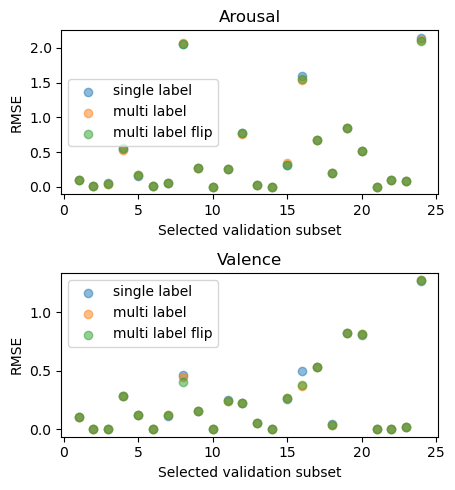

In [46]:
import matplotlib.pyplot as plt

s1 = S1()

validation_pairs = []
for sub in s1.train_subs[::5]:
    for vid in s1.train_vids[::2]:
        validation_pairs.append((sub, vid))

raw_rmse_arousal = pd.read_csv('AutogluonModels/scenario_1/output/comparison_raw_rmse_arousal.csv')
raw_rmse_valence = pd.read_csv('AutogluonModels/scenario_1/output/comparison_raw_rmse_valence.csv')
multilabel_rmse = pd.read_csv('AutogluonModels/scenario_1/output/comparison_raw_multi_label_rmse.csv')
multilabel_rmse_arousal = multilabel_rmse['arousal_rmse']
multilabel_rmse_valence = multilabel_rmse['valence_rmse']

fig, axes = plt.subplots(2, 1, figsize=(4.74, 5))
axes = axes.flatten()
axes[0].set_title('Arousal')
axes[0].set_ylabel('RMSE')
axes[0].set_xlabel('Selected validation subset')
axes[0].scatter(np.arange(1, 25), raw_rmse_arousal['root_mean_squared_error'], alpha=0.5, label='single label')
axes[0].scatter(np.arange(1, 25), multilabel_rmse_flip_arousal, alpha=0.5, label='multi label')
axes[0].scatter(np.arange(1, 25), multilabel_rmse_arousal, alpha=0.5, label='multi label flip')
axes[0].legend()

axes[1].set_title('Valence')
axes[1].set_ylabel('RMSE')
axes[1].set_xlabel('Selected validation subset')
axes[1].scatter(np.arange(1, 25), raw_rmse_valence['root_mean_squared_error'], alpha=0.5, label='single label')
axes[1].scatter(np.arange(1, 25), multilabel_rmse_flip_valence, alpha=0.5, label='multi label')
axes[1].scatter(np.arange(1, 25), multilabel_rmse_valence, alpha=0.5, label='multi label flip')

plt.legend()
plt.tight_layout()
plt.savefig('/home/celia/Pictures/comparison_single_multi.pdf')
plt.show()

In [29]:
len(raw_rmse_arousal['root_mean_squared_error']), len(np.arange(0, 24))

(24, 24)

In [10]:
raw_rmse_arousal['root_mean_squared_error'].mean(), multilabel_rmse_arousal.mean()

(0.4495746558801385, 0.44544823885962076)

In [11]:
raw_rmse_valence['root_mean_squared_error'].mean(), multilabel_rmse_valence.mean()

(0.25092245151177567, 0.24422178300978814)

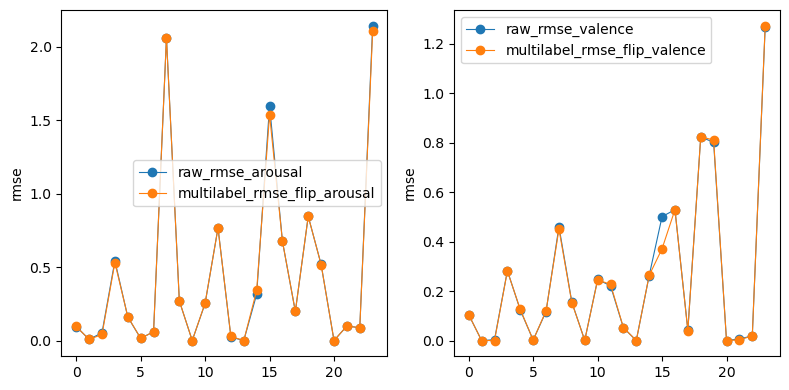

In [9]:
import matplotlib.pyplot as plt

s1 = S1()

validation_pairs = []
for sub in s1.train_subs[::5]:
    for vid in s1.train_vids[::2]:
        validation_pairs.append((sub, vid))

raw_rmse_arousal = pd.read_csv('AutogluonModels/scenario_1/output/comparison_raw_rmse_arousal.csv')
raw_rmse_valence = pd.read_csv('AutogluonModels/scenario_1/output/comparison_raw_rmse_valence.csv')
multilabel_rmse_flip = pd.read_csv('AutogluonModels/scenario_1/output/comparison_raw_multi_label_flip_rmse.csv')
multilabel_rmse_flip_arousal = multilabel_rmse_flip['arousal_rmse']
multilabel_rmse_flip_valence = multilabel_rmse_flip['valence_rmse']

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes = axes.flatten()
axes[0].set_ylabel('rmse')
axes[0].plot(raw_rmse_arousal['root_mean_squared_error'], 'o-', linewidth=0.8, label='raw_rmse_arousal')
axes[0].plot(multilabel_rmse_flip_arousal, 'o-', linewidth=0.8, label='multilabel_rmse_flip_arousal')
axes[0].legend()

axes[1].set_ylabel('rmse')
axes[1].plot(raw_rmse_valence['root_mean_squared_error'], 'o-', linewidth=0.8, label='raw_rmse_valence')
axes[1].plot(multilabel_rmse_flip_valence, 'o-', linewidth=0.8, label='multilabel_rmse_flip_valence')

plt.legend()
plt.tight_layout()
plt.show()

In [12]:
raw_rmse_arousal['root_mean_squared_error'].mean(), multilabel_rmse_flip_arousal.mean()

(0.4495746558801385, 0.4462014503629897)

In [13]:
raw_rmse_valence['root_mean_squared_error'].mean(), multilabel_rmse_flip_valence.mean()

(0.25092245151177567, 0.24570704053167913)

In [14]:
raw_rmse_arousal

,Unnamed: 0,subjectID,videoID,root_mean_squared_error
0,0,1,1,9.541739e-02
1,1,1,10,7.864991e-03
2,2,1,13,5.281378e-02
3,3,1,18,5.432367e-01
4,4,9,1,1.598567e-01
5,5,9,10,1.492970e-02
6,6,9,13,5.988446e-02
7,7,9,18,2.059423e+00
8,8,17,1,2.697825e-01
9,9,17,10,9.346008e-08


### training on preprocessed data